July 9th, 2025 


# ECDI-like Linear Theory 
#### [V. Roytershteyn and G. L. Delzanno. *Nonlinear coupling of whistler waves to oblique electrostatic turbulence enabled by cold plasma*. Physics of Plasmas, 28(4):042903, 04 2021](https://pubs.aip.org/aip/pop/article-abstract/28/4/042903/263604/Nonlinear-coupling-of-whistler-waves-to-oblique?redirectedFrom=fulltext)


Author: Opal Issan (oissan@ucsd.edu)

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from QLT_equations.general_plasma_equations import Z, Z_prime, I, J

In [3]:
from scipy.ndimage import gaussian_filter

In [4]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Electrostatic perpendicular dispersion relation 
The dispersion relation is 
\begin{align*}
    k_{\perp}^2 + \epsilon_{c}(\omega, k_{\perp}) &= \epsilon_{i}(\omega, k_{\perp})\\
    \epsilon_{c}(\omega, k_{\perp}) &=- \frac{n_{c}}{n_{e}} \frac{4\omega_{pe}^2}{\alpha_{\perp c}^2} \sum_{n=1}^{\infty} \overbrace{\exp(-\lambda) I_{n}(\lambda)}^{\texttt{ive(n, } \lambda)} \frac{ n^2\Omega_{ce}^2}{\omega^2 - n^2 \Omega_{ce}^2}\\
    \epsilon_{i}(\omega, k_{\perp})&=\frac{\omega_{pi}^2}{\alpha_{i}^2} [\underbrace{J_{m*}(a)}_{\texttt{jv(m*, a)}}]^2 Z{'}\left(\frac{\omega + m_{*} \omega_{0}}{k \alpha_{i}}\right)\\
    a &\coloneqq \frac{k_{\perp} |V_{Dc}|}{ \omega_{0}}\\
    \lambda &\coloneqq \frac{1}{2} \frac{k_{\perp}^2 \alpha_{\perp c}^2}{\Omega_{ce}^2} 
\end{align*} 

In [5]:
# normalization 
# time is normalized to the electron cyclotron frequency 1/Omega_ce
# space is normalized to electron inertial length d_e
n_c = 0.8 # n^e_0
omega_0 = 0.5 # Omega_ce

omega_pe = 4 # Omgea_{ce}
alpha_perp_c = 0.0079 # d_e x Omega_ce
alpha_i =  alpha_perp_c / np.sqrt(1836) # d_e x Omega_ce

v_0 = 0.65 * alpha_perp_c # d_e x Omega_ce
omega_pi = omega_pe / np.sqrt(1836) # Omega_ce

In [6]:
def sum_bessel(lambda_, omega, n_max=20):
    res =0 
    for n in range(1, n_max):
        res += I(m=n, Lambda=lambda_) * (n**2) / (omega**2 - n**2)
    return res

def cold_electron_response(k_perp, omega, n_max, omega_pe, alpha_perp_c, n_c):
    lambda_ =  (k_perp*alpha_perp_c/np.sqrt(2))**2
    return -n_c * 4 * (omega_pe**2) /(alpha_perp_c**2) * sum_bessel(lambda_=lambda_, omega=omega, n_max=n_max)


def THETA(omega_pi_, alpha_i_, n, M, k_perp, v_0_, omega_0_, omega,  m_max=20):
    # magnitude of the wavevector
    k_abs =  np.abs(k_perp)
    # Bessel argument ion Doppler-shifted
    a = k_perp * np.abs(v_0_) / omega_0_
    res = 0
    for m in range(-m_max, m_max + 1):
        res += (omega_pi_ ** 2) / (alpha_i_ ** 2) * J(m=m - n, Lambda=-a) * J(m=m - M, Lambda=-a) \
               * Z_prime(z=(omega + m * omega_0_) / (alpha_i_ * k_abs))
    return res


def D_matrix_opal(omega, k_perp, n_c_, omega_pe_, alpha_c_perp_, omega_0_, v_0_, alpha_i_, omega_pi_,
                  N=5):
    # initialize matrix
    D_mat = np.zeros((N * 2 + 1, N * 2 + 1), dtype="complex128")
    for n in range(-N, N + 1):
        i1 = n + N
        # cold electron components
        D_mat[i1, i1] += k_perp**2 + cold_electron_response(k_perp=k_perp, omega=omega + n * omega_0_, 
                                                            n_max=20, omega_pe=omega_pe, alpha_perp_c=alpha_c_perp_, n_c=n_c_)

        for M in range(-N, N + 1):
            i2 = M + N
            D_mat[i1, i2] += -THETA(omega_pi_=omega_pi_, alpha_i_=alpha_i_, n=n, M=M, k_perp=k_perp,
                                    v_0_=v_0_, omega_0_=omega_0_, omega=omega)
    return D_mat


def ion_response(omega_pi_, alpha_i_, m_star_, k_perp, v_0_, omega_0_, omega):
    # Bessel argument ion Doppler-shifted
    a = k_perp * np.abs(v_0_) / omega_0
    return (omega_pi_ ** 2) / (alpha_i_ ** 2) * (J(m=m_star_, Lambda=-a) ** 2) * Z_prime(
        z=(omega + m_star_ * omega_0_) / (alpha_i_ * np.abs(k_perp)))



In [7]:
def disp_k_approx(k_perp,
                  n_c_,
                  omega_pe_=omega_pe,
                  omega_pi_=omega_pi,
                  omega_0_=omega_0,
                  v_0_=v_0,
                  alpha_i_=alpha_i,
                  alpha_perp_c_=alpha_perp_c,
                  m_star=-3):
    return lambda omega: k_perp ** 2 \
                         + cold_electron_response(k_perp=k_perp, omega=omega, n_max=20, omega_pe=omega_pe, alpha_perp_c=alpha_perp_c_, n_c=n_c_) \
                         - ion_response(omega_pi_=omega_pi_, alpha_i_=alpha_i_, m_star_=m_star, k_perp=k_perp, v_0_=v_0_,
                                        omega_0_=omega_0_, omega=omega)


def disp_k_full(k_perp,
                n_c_,
                omega_pe_=omega_pe,
                omega_pi_=omega_pi,
                omega_0_=omega_0,
                v_0_=v_0,
                alpha_i_=alpha_i,
                alpha_perp_c_=alpha_perp_c):
    return lambda omega: np.linalg.det(
        D_matrix_opal(omega=omega, k_perp=k_perp, n_c_=n_c_, omega_pe_=omega_pe_, alpha_c_perp_=alpha_perp_c_,
                      omega_0_=omega_0_, v_0_=v_0_,
                      alpha_i_=alpha_i_, omega_pi_=omega_pi_))

In [8]:
k_perp = 130 

sol_approx = scipy.optimize.newton(disp_k_approx(k_perp=k_perp, n_c_=0.5), 1.1+ 0.0005j, tol=1e-16, maxiter=100, x1=1.5 + 1e-2j)
print(sol_approx)
print("omega_k + i gamma = ", sol_approx)
print("dispersion residual approx = ", abs(disp_k_approx(k_perp=k_perp, n_c_=0.8)(sol_approx)))

sol_full = scipy.optimize.newton(disp_k_full(k_perp=k_perp, n_c_=0.1), sol_approx, tol=1e-15, maxiter=100)
print(sol_full)
print("omega_k + i gamma = ", sol_full)
print("dispersion residual full = ", abs(disp_k_full(k_perp=k_perp, n_c_=0.8)(sol_full)))

(1.6271331913498372-3.2340860161004113e-14j)
omega_k + i gamma =  (1.6271331913498372-3.2340860161004113e-14j)
dispersion residual approx =  10128.642218385115
(1.661969488625739-7.57768127404833e-23j)
omega_k + i gamma =  (1.661969488625739-7.57768127404833e-23j)
dispersion residual full =  4.580865346255913e+49


In [10]:
k_perp_ = np.linspace(150, 250, 60)

n_c_ = np.linspace(0.2, 0.95, 100)

sol_approx_ = np.zeros((len(k_perp_), len(n_c_)), dtype="complex128")
sol_full_ = np.zeros((len(k_perp_), len(n_c_)), dtype="complex128")

In [11]:
for jj in range(len(n_c_)):
    for ii in range(len(k_perp_)):
        try:
            sol_approx_[ii, jj] = scipy.optimize.newton(disp_k_approx(k_perp=k_perp_[ii], n_c_=n_c_[jj]), 1.1+ 0.0005j, tol=1e-16, maxiter=100, x1=1.5 + 1e-2j)
            sol_full_[ii, jj] = scipy.optimize.newton(disp_k_full(k_perp=k_perp_[ii], n_c_=n_c_[jj]), sol_approx_[ii, jj], tol=1e-15, maxiter=100, x1=1.5 + 1e-2j)
    
        except:
            print("dispersion residual approx = ", abs(disp_k_approx(k_perp=k_perp_[ii], n_c_=n_c_[jj])(sol_approx_[ii, jj])))
            print("dispersion residual full = ", abs(disp_k_full(k_perp=k_perp_[ii], n_c_=n_c_[jj])(sol_full_[ii, jj])))

dispersion residual approx =  6.442754563123395e-11
dispersion residual full =  nan


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_26027/1550072659.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  res += I(m=n, Lambda=lambda_) * (n**2) / (omega**2 - n**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_26027/1550072659.py:4: RuntimeWarning: invalid value encountered in scalar divide
  res += I(m=n, Lambda=lambda_) * (n**2) / (omega**2 - n**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_26027/1550072659.py:9: RuntimeWarning: invalid value encountered in scalar multiply
  return -n_c * 4 * (omega_pe**2) /(alpha_perp_c**2) * sum_bessel(lambda_=lambda_, omega=omega, n_max=n_max)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


dispersion residual approx =  4.4715939667985035e-11
dispersion residual full =  nan
dispersion residual approx =  5.989225034203737e-11
dispersion residual full =  nan
dispersion residual approx =  6.600176971044904e-11
dispersion residual full =  nan
dispersion residual approx =  9.112693272687351e-13
dispersion residual full =  nan


/opt/anaconda3/envs/rom/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:380: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q0 / q1 * p1 + p0) / (1 - q0 / q1)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


dispersion residual approx =  1.0012351454979886e-11
dispersion residual full =  nan
dispersion residual approx =  2.797435536814832e-11
dispersion residual full =  nan
dispersion residual approx =  9.028109361643523e-11
dispersion residual full =  nan
dispersion residual approx =  3.616617574884779e-11
dispersion residual full =  nan
dispersion residual approx =  4.414798204140334e-12
dispersion residual full =  nan
dispersion residual approx =  274471.5028988635
dispersion residual full =  nan


/Users/oissan/PycharmProjects/QLT_whistler/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


dispersion residual approx =  1.0015190977966963e-10
dispersion residual full =  nan


In [12]:
sol_full_.imag[np.where(sol_full_.imag>0.02)] = 0

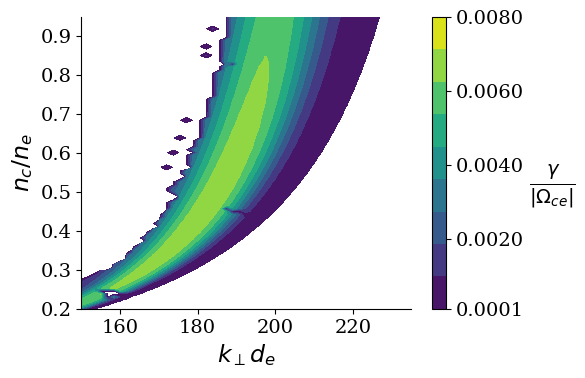

In [128]:
fig, ax = plt.subplots(figsize=(6, 4))
pos = ax.contourf(k_perp_, n_c_, gaussian_filter(sol_full_.imag.T, 0), vmin=1e-4, vmax=0.008, levels=np.linspace(1e-4, 0.008, 10))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{ce}|}$', labelpad=20, rotation=0, fontsize=20)
cbar.ax.set_yticks([1e-4, 0.002, 0.004, 0.006, 0.008])
ax.set_xlabel("$k_{\perp}d_{e}$", fontsize=17)
ax.set_ylabel("$n_{c}/n_{e}$", fontsize=17)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(150, 235)
ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
plt.savefig("../figs/vadim_2021/perp_n_c_full_imag.png", dpi=300, bbox_inches='tight')

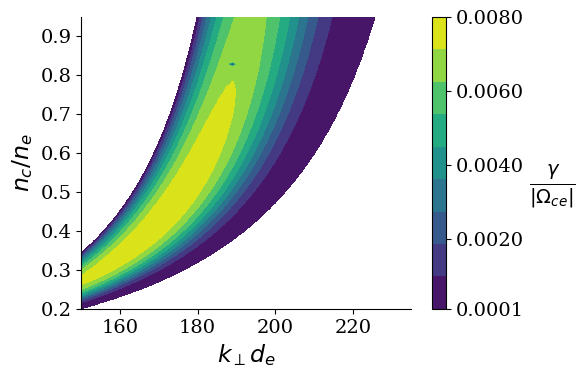

In [127]:
fig, ax = plt.subplots(figsize=(6, 4))
pos = ax.contourf(k_perp_, n_c_, gaussian_filter(sol_approx_.imag.T, 0.), vmin=1e-4, vmax=0.008, levels=np.linspace(1e-4, 0.008, 10))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{ce}|}$', labelpad=20, rotation=0, fontsize=20)
cbar.ax.set_yticks([1e-4, 0.002, 0.004, 0.006, 0.008])
ax.set_xlabel("$k_{\perp}d_{e}$", fontsize=17)
ax.set_ylabel("$n_{c}/n_{e}$", fontsize=17)
ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(150, 235)

plt.tight_layout()
plt.savefig("../figs/vadim_2021/perp_n_c_approx_imag.png", dpi=300, bbox_inches='tight')

In [121]:
sol_temp = np.copy(sol_approx_)
sol_temp.real[np.where(sol_approx_.imag<1e-10)] = 0
sol_temp.real[np.where(sol_approx_.imag>0.008)] = 0

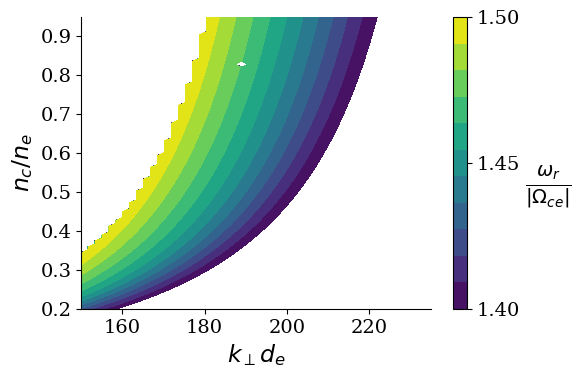

In [129]:
fig, ax = plt.subplots(figsize=(6, 4))
pos = ax.contourf(k_perp_, n_c_, gaussian_filter(sol_temp.real.T, 0), vmin=1.4, vmax=1.5, levels=np.linspace(1.4, 1.5, 12))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{ce}|}$', labelpad=20, rotation=0, fontsize=20)
cbar.ax.set_yticks([1.4, 1.45, 1.5])
ax.set_xlabel("$k_{\perp}d_{e}$", fontsize=17)
ax.set_ylabel("$n_{c}/n_{e}$", fontsize=17)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax.set_xlim(150, 235)

plt.tight_layout()
plt.savefig("../figs/vadim_2021/perp_n_c_approx_real.png", dpi=300, bbox_inches='tight')

In [123]:
sol_full = np.copy(sol_full_)
sol_full.real[np.where(sol_full_.imag<1e-10)] = 0
sol_full.real[np.where(sol_full_.imag>0.008)] =0

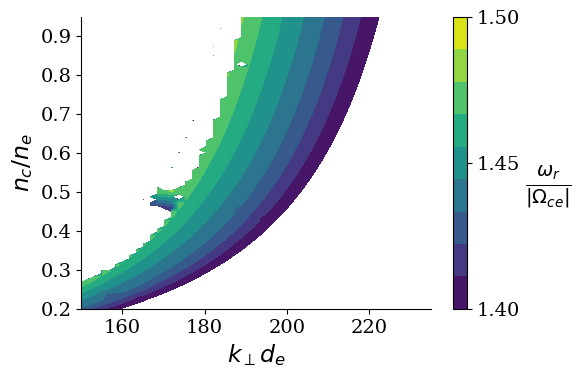

In [130]:
fig, ax = plt.subplots(figsize=(6, 4))
pos = ax.contourf(k_perp_, n_c_, gaussian_filter(sol_full.real.T, 0.), vmin=1.4, vmax=1.5, levels=np.linspace(1.4, 1.5, 10))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{ce}|}$', labelpad=20, rotation=0, fontsize=20)
cbar.ax.set_yticks([1.4, 1.45, 1.5])
ax.set_xlabel("$k_{\perp}d_{e}$", fontsize=17)
ax.set_ylabel("$n_{c}/n_{e}$", fontsize=17)
ax.set_xlim(150, 235)
ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("../figs/vadim_2021/perp_n_c_full_real.png", dpi=300, bbox_inches='tight')

In [83]:
# fig, ax = plt.subplots(figsize=(6, 4.2))
# ax.plot(k_perp_, sol_full_.real, linewidth=3, color="tab:Blue", label="Eq. (9) $\Rightarrow$ full")
# ax.plot(k_perp_, sol_approx_.real, linewidth=3, ls="--", color="tab:red", label="Eq. (10) $\Rightarrow$ approx")


# legend = ax.legend(ncols=1, fancybox=False, shadow=False,  loc="upper right")
# legend.get_frame().set_alpha(0)


# ax.set_ylabel(r'$\frac{\omega_r}{|\Omega_{ce}|}$', fontsize=22, labelpad=20, rotation=0)
# ax.set_xlabel('$k_{\perp}d_{e}$', fontsize=15)
# ax.set_xticks([180, 200, 220, 240])
# ax.set_ylim(1.3, 1.5)
# ax.set_yticks([1.3, 1.4, 1.5])
# ax.set_xlim(195, 245)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.grid(alpha=0.5)
# plt.tight_layout()
# plt.savefig("../figs/vadim_2021/vadim_fig5_a_n_c_.png", dpi=300, bbox_inches='tight')

In [64]:
# fig, ax = plt.subplots(figsize=(6, 4.2))

# ax.plot(k_perp_, sol_full_.imag, linewidth=3, color="tab:Blue", label="Eq. (9) $\Rightarrow$ full")
# ax.plot(k_perp_, sol_approx_.imag, linewidth=3, ls="--", color="tab:red", label="Eq. (10) $\Rightarrow$ approx")


# legend = ax.legend(ncols=1, fancybox=False, shadow=False,  loc="upper right")
# legend.get_frame().set_alpha(0)

# ax.set_xlabel('$k_{\perp}d_{e}$', fontsize=15)
# ax.set_xticks([180, 200, 220, 240])
# #ax.set_ylim(-0.0001, 0.0075)
# ax.set_xlim(175, 245)
# #ax.set_yticks([0, 0.0025, 0.005, 0.0075])
# ax.set_yticklabels([0, 0.0025, 0.005, 0.0075])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.grid(alpha=0.5)
# plt.tight_layout()
# plt.savefig("../figs/vadim_2021/vadim_fig5_b.png", dpi=300, bbox_inches='tight')

# understanding the instability 

In [42]:
ion_feedback = ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-3, v_0=v_0, omega=sol_, omega_0=omega_0, k_perp=k_perp_)

electron_feedback = k_perp_**2 +cold_electron_response(k_perp=k_perp_, 
                                                       omega=sol_, n_max=7, 
                                                       omega_pe=omega_pe, alpha_perp_c=alpha_perp_c, n_c=n_c)

NameError: name 'sol_' is not defined

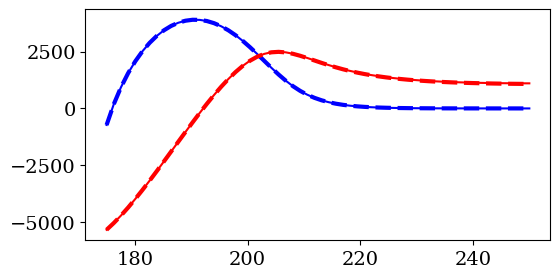

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(k_perp_, electron_feedback.imag, color="blue", ls="--", linewidth=3)
ax.plot(k_perp_, ion_feedback.imag, color="blue")
ax.plot(k_perp_, electron_feedback.real, color="red", ls="--", linewidth=3)
ax.plot(k_perp_, ion_feedback.real, color="red")

#ax.set_yscale("log")

#

In [17]:
k_perp = 190

In [18]:
omega_ = np.linspace(0.1, 5, 500)
electron_feedback = k_perp**2 +cold_electron_response(k_perp=k_perp, omega=omega_, n_max=50, 
                                                           omega_pe=omega_pe, alpha_perp_c=alpha_perp_c, n_c=n_c)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_3548/2157211366.py:4: RuntimeWarning: divide by zero encountered in divide
  res += I(m=n, Lambda_e=lambda_) * (n**2) / (omega**2 - n**2)


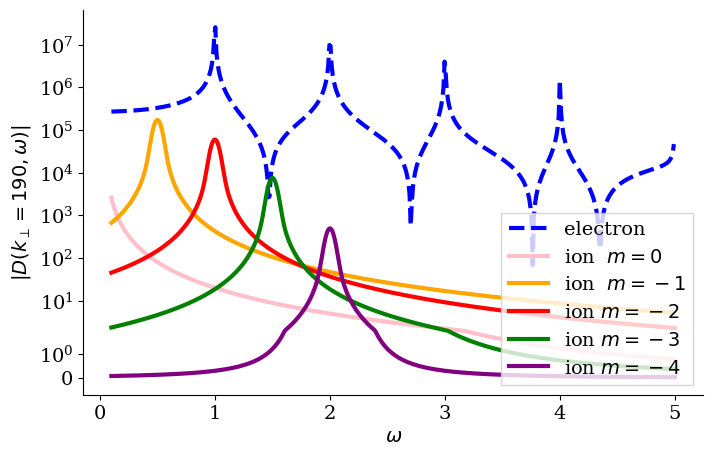

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(omega_, np.abs(electron_feedback), color="blue", ls="--", linewidth=3, label="electron")

ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=0, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="pink",  linewidth=3, label="ion  $m=0$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-1, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="orange",  linewidth=3, label="ion  $m=-1$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-2, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="red",  linewidth=3, label="ion $m=-2$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-3, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="green",  linewidth=3, label="ion $m=-3$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-4, v_0=v_0, omega=omega_, omega_0=omega_0, k_perp=k_perp)), color="purple",  linewidth=3, label="ion $m=-4$")

legend = ax.legend(ncols=1, fancybox=False, shadow=False,  loc="lower right")
#legend.get_frame().set_alpha(0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("$\omega$")
ax.set_ylabel("$|D(k_{\perp} =190, \omega)|$")
ax.set_yscale("symlog")
plt.savefig("../figs/vadim_2021/side_bands_ecdi.png", dpi=300)